# LSTM recipe generator analysis

Note: This notebook is designed to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Install Google Translate library to convert generated texts to other languages.

In [2]:
pip install -q googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langsmith 0.3.1 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
openai 1.59.9 requires httpx<1,>=0.23.0, but you 

Import modules and set random seeds.

In [3]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import saving
from googletrans import Translator

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [4]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print(f'Vocabulary size: {VOCAB_SIZE}')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Vocabulary size: 30522


Mount the google drive and load the trained model.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

model_file = '/content/gdrive/My Drive/LSTM_recipe_generator.keras'
lstm_model = saving.load_model(model_file)
lstm_model.summary()

Mounted at /content/gdrive


Model: "LSTM_next_word_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_embedding (Embedding)           │ (None, None, 512)           │      15,627,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM (LSTM)                          │ (None, None, 512)           │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, None, 30522)         │      15,657,786 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,152,752 (382.05 MB)

 Trainable params: 33,384,250 (127.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,768,502 (254.70 MB)

Define a function to generate new texts.

In [6]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_text(prompt, temp=0.1, lang='en'):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]
    answer = prompt
    print(answer, end='')

    c = 1
    for i in range(512):
        probs = lstm_model.predict(np.array([input_ids]), verbose=0)[0][-1]
        next_token, _ = sample_from(probs, temp)
        input_ids = np.append(input_ids, next_token)

        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        if next_word.startswith('##'):
            next_word = next_word[2:]
        elif next_word not in ['.', ',', ':', ';', '?', '!']:
            next_word = ' ' + next_word
        print(next_word, end='')
        answer += next_word
        if len(answer) > c * 100:
            c += 1
            print('')
    print('')

    if lang == 'en':
        return answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return translated.text

Generate some sample texts.

In [7]:
gen_text('Recipe for beef', temp=1.0, lang='ja')

Recipe for beef tips off from costa rica: add honey and salt; heat to a simmer. cook until browned, 5
 to 7 minutes. pat dry beans on a paper towel lined with paper towels. drain. dice onion if using a food
 mill, and strips of salsa in 2 forks seasoning pan. reduce heat to medium low and simmer until noodles
 are soft, about 15 minutes. increase heat to medium - high. using tongs,


'コスタリカの牛肉の先端のレシピ：蜂蜜と塩を加えます。煮るまで加熱します。5〜7分茶色になるまで調理します。ペーパータオルで裏打ちされたペーパータオルにドライゲンをパットします。ドレイン。ダイスタマネギフードミルを使用している場合はタマネギ、2つのフォークシーズンパンにサルサのストリップを使用します。熱を中程度の低くし、麺が柔らかくなるまで約15分間煮ます。熱を中程度に増やします - 高。トングを使用して、'

In [8]:
gen_text('Recipe for beef', temp=0.5, lang='ja')

Recipe for beef tips: preheat oven to 350 degrees f ( 175 degrees c ). lightly grease a 9x13 inch baking
 dish. combine the butter, brown sugar, brown sugar, salt, and pepper in a bowl until well combined
. pour the mixture into the prepared pan. bake in the preheated oven until the chicken is no longer
 pink in the center and the juices run clear, about 20 minutes. an instant - read thermometer inserted
 into the center should read at least 160 degrees f ( 70 degrees c ).


'牛肉のチップのレシピ：オーブンを350度F（175度C）に予熱します。9x13インチのベーキング皿に軽く塗ります。バター、ブラウンシュガー、ブラウンシュガー、塩、コショウをボウルに混ぜ合わせます。混合物を準備したパンに注ぎます。鶏肉が中央でピンク色にならなくなり、ジュースが約20分透けて走るまで、予熱したオーブンで焼きます。インスタント - 中央に挿入された読み取り温度計は、少なくとも160度F（70度C）を読み取る必要があります。'

In [9]:
gen_text('Recipe for beef', temp=0.1, lang='ja')

Recipe for beef tips: in a large skillet, heat the oil over medium - high heat. add the onion, garlic
, and salt. cook and stir until the onion has softened and turned translucent, about 5 minutes. add the
 chicken broth, and bring to a boil. reduce heat to low, cover, and simmer for 20 minutes. stir the
 flour, salt, and black pepper into the skillet. stir the flour mixture into the mixture, and stir
 until the mixture has been absorbed, about 1 minute. pour the


'牛肉の先端のレシピ：大きなフライパンで、中程度の強火で油を加熱します。タマネギ、ニンニク、塩を加えます。タマネギが柔らかくなり、半透明になるまで約5分間調理してかき混ぜます。チキンスープを加えて、沸騰させます。熱を低くし、覆い、20分間煮ます。小麦粉、塩、黒胡pepperをフライパンに入れます。小麦粉の混合物を混合物に混ぜ、混合物が吸収されるまで約1分間かき混ぜます。注ぎます'

In [10]:
gen_text('Recipe for apple', temp=1.0, lang='ja')

Recipe for apple bread: preheat oven to 350 degrees f ( 175 degrees c ). grease 8 muffin pan. in a large
 bowl combine brown sugar, half - cocoa juice, vanilla and confections. slowly stream sugar mixture
 into an - half - cup butter - butter mixture until just enough to form a smooth batter underneath
. spoon for 1 tablespoon - butter mixture each tart mixture. roll each crescent cake horizontally in
 to my any crust. spoon and wilhelm into muffin


'リンゴのパンのレシピ：オーブンを350度F（175度C）に予熱します。グリース8マフィンパン。大きなボウルに、黒砂糖、半分のココアジュース、バニラ、菓子を混ぜます。砂糖の混合物を、下に滑らかなバッターを形成するのに十分になるまで、半分のカップバター - バターの混合物にゆっくりと流れます。大さじ1のスプーン - 各タルト混合物のバター混合。各三日月ケーキを水平に丸めて私の皮に巻き込みます。スプーンとウィルヘルムがマフィンに'

In [11]:
gen_text('Recipe for apple', temp=0.5, lang='ja')

Recipe for apple brickle bread: preheat the oven to 350 degrees f ( 175 degrees c ). grease an 8 - inch
 square baking dish. combine the flour, salt, baking soda, and cinnamon in a bowl. mix together the
 eggs, sugar, and vanilla extract together in a bowl, and mix in the eggs. pour the flour mixture into
 the prepared pan. bake in preheated oven for 30 to 40 minutes, or until a toothpick inserted into
 the center of the cake comes out clean.


'リンゴレンガパンのレシピ：オーブンを華氏350度（175度C）に予熱します。8インチの正方形のベーキング皿にグリースを塗ります。小麦粉、塩、重曹、シナモンをボウルに混ぜます。卵、砂糖、バニラの抽出物をボウルに混ぜ合わせ、卵を混ぜます。小麦粉の混合物を準備した鍋に注ぎます。予熱したオーブンで30〜40分間焼くか、ケーキの中央に挿入されたつまようじがきれいになるまで焼きます。'

In [12]:
gen_text('Recipe for apple', temp=0.1, lang='ja')

Recipe for apple brickle bread: preheat oven to 350 degrees f ( 175 degrees c ). grease a 9x13 - inch
 baking pan. combine the flour, baking powder, baking soda, salt, and baking soda together in a bowl
. mix together the flour, baking powder, and salt; set aside. in a large bowl, mix the flour, baking
 soda, salt, and baking soda together. add the flour, baking soda, salt, and baking powder. mix until
 the dough is just moistened. fold in the raisins and walnuts. spoon the batter into the prepared mu
ffin cups. bake in the preheated oven until a toothpick inserted into the center of the


'リンゴレンガパンのレシピ：オーブンを350度F（175度C）に予熱します。9x13 -インチベーキングパンをグリースします。小麦粉、ベーキングパウダー、重曹、塩、重曹をボウルに混ぜます。小麦粉、ベーキングパウダー、塩を混ぜます。脇に置いてください。大きなボウルに、小麦粉、重曹、塩、重曹を混ぜます。小麦粉、重曹、塩、ベーキングパウダーを加えます。生地が湿らせるまで混ぜます。レーズンとクルミを折ります。バッターを準備したマフィンカップにスプーンで入れます。つまようじが中心に挿入されるまで、予熱したオーブンで焼きます'

Define a function to show top 10 tokens following the input text.

In [13]:
def top_k(prompt, temp=0.1):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    probs = lstm_model.predict(np.array([input_ids]), verbose=0)[0][-1]
    _, probs = sample_from(probs, temp)
    probs = list(zip(probs, range(len(probs))))
    top_k = sorted(probs, reverse=True)[:10]
    probs = [p for p, _ in top_k]
    labels = [tokenizer.convert_ids_to_tokens([token])[0] for _, token in top_k]

    n = len(probs)
    fig = plt.figure(figsize=(6, 2))
    subplot = fig.add_subplot(1, 1, 1)
    subplot.set_xticks(range(n))
    subplot.set_xlim([-0.5, n - 0.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(labels)
    subplot.set_title(prompt, fontsize=11)
    _ = subplot.bar(range(n), probs, align='center')

Show top 10 tokens for a sample text.

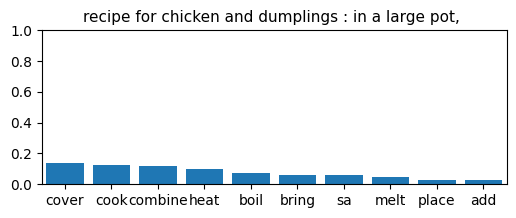

In [14]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=1.0)

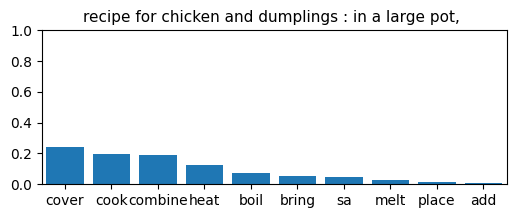

In [15]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.5)

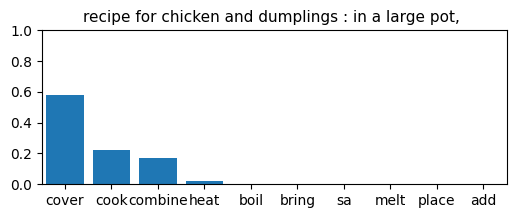

In [22]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.1)